In [5]:
import ee
from drought.data import ee_climate, pipeline
import drought.data.df_extensions as dfext
from drought.visualization import plot
import geemap
import matplotlib.pyplot as plt
import pandas as pd
import importlib

## Prerequisites

Before running the notebook, make sure to authenticate with Google Earth 
Engine. 

You can do so by running ```earthengine authenticate``` on the command line
or uncommenting the authentication cell below. See [here](https://developers.google.com/earth-engine/guides/python_install#authentication) for more details.

### Earth Engine Initialization

In [ ]:
# Uncomment if you want to authenticate within jupyter notebook.
ee.Authenticate()

In [2]:
ee.Initialize()

## Get Climate Data

In [3]:
# Dates of interest.
start_date = ee.Date('2019-01-01')
end_date = ee.Date('2023-01-01')

# Get regions of interest.
ee_geoms = pipeline.get_ee_polygons()

# Specify resolution.
scale = 5000

# Fetch climate data from Earth Engine as Pandas DataFrame.
climate_monthly_pdf = ee_climate.get_monthly_climate_data_as_pdf(
        start_date, end_date, ee_geoms, scale)

### Plot total monthly averages

In [5]:
# Calculate monthly mean for all three years in aggregate.
total_monthly_mean = climate_monthly_pdf.groupby(['month', 'polygon_id']) \
                                .mean(numeric_only=True).reset_index() \
                                .drop(columns=['year'])

In [ ]:
# Palette for plotting. Colors can be accessed by indexing - plot.palette[i]
plot.palette

In [ ]:
# Plot aggregate monthly precipitation per region.
fig = plot.barplot_per_polygon(total_monthly_mean,
                              x='month', 
                              y='precipitation', 
                              ylabel="Precipitation mm / month",
                              title="Aggregate monthly precipitation per region 2019-2022",
                              color=plot.palette[5])
# Mark the 100mm precipitation line that signifies a dry month.
[subplot.axhline(y=100, color = 'r', linestyle = 'dotted', linewidth=3) 
 for subplot in fig.get_axes()]
plt.show()

In [ ]:
# Plot aggregate monthly radiation per region.
fig = plot.barplot_per_polygon(total_monthly_mean,
                              x='month', 
                              y='radiation', 
                              ylabel="Radiation",
                              title="Mean monthly radiation per region 2019-2022",
                              color=plot.palette[0],
                              sharey=True)
plt.show()

In [ ]:
# Plot aggregate monthly temperature per region.
fig = plot.barplot_per_polygon(total_monthly_mean,
                              x='month', 
                              y='temperature', 
                              ylabel="Temperature",
                              title="Mean monthly temperature per region 2019-2022",
                              color=plot.palette[7],
                              sharey=True)
plt.show()

In [ ]:
# Plot aggregate monthly fpar per region.
fig = plot.barplot_per_polygon(total_monthly_mean,
                              x='month', 
                              y='fpar', 
                              ylabel="Fpar",
                              title="Mean monthly Fpar per region 2019-2022",
                              color=plot.palette[3],
                              sharey=True)
plt.show()

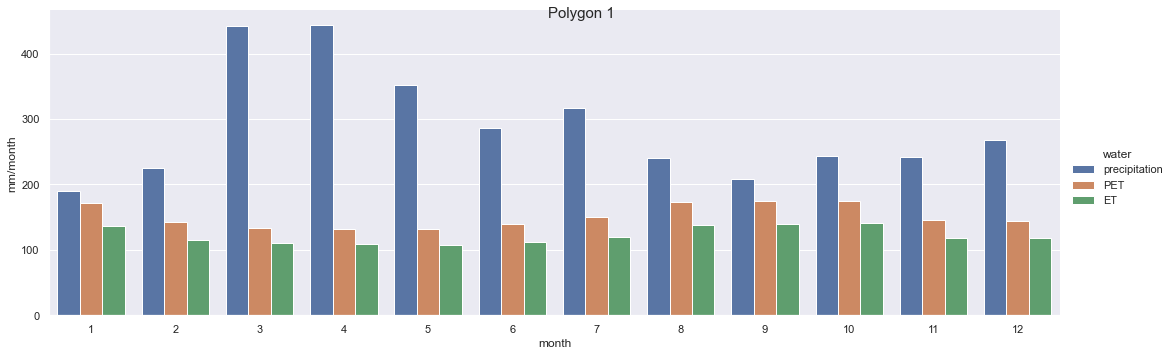

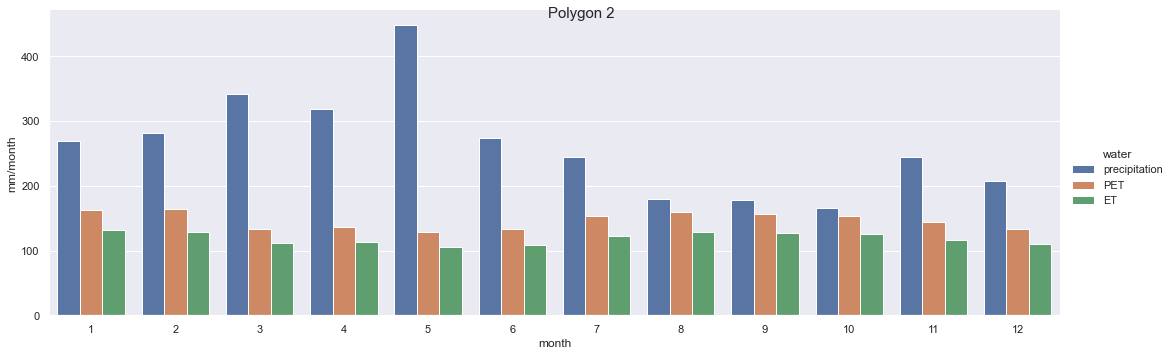

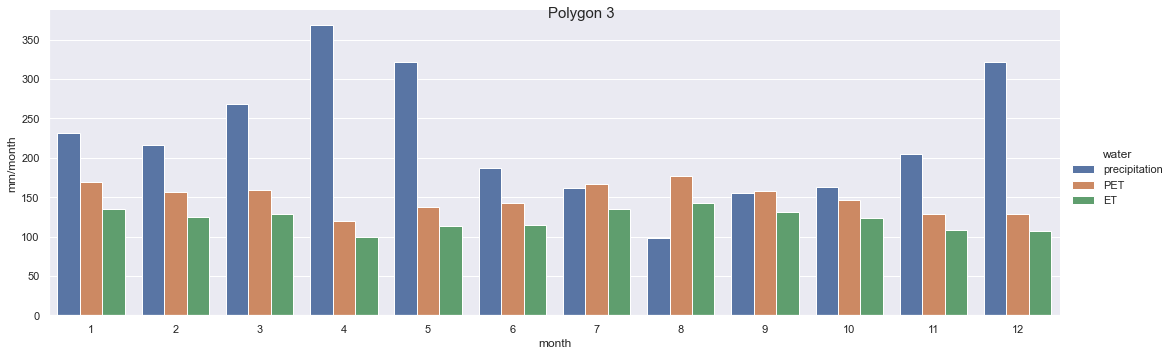

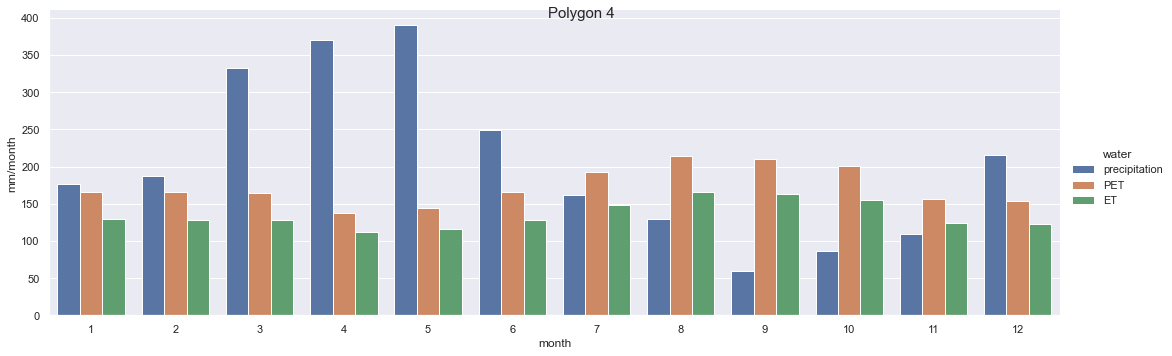

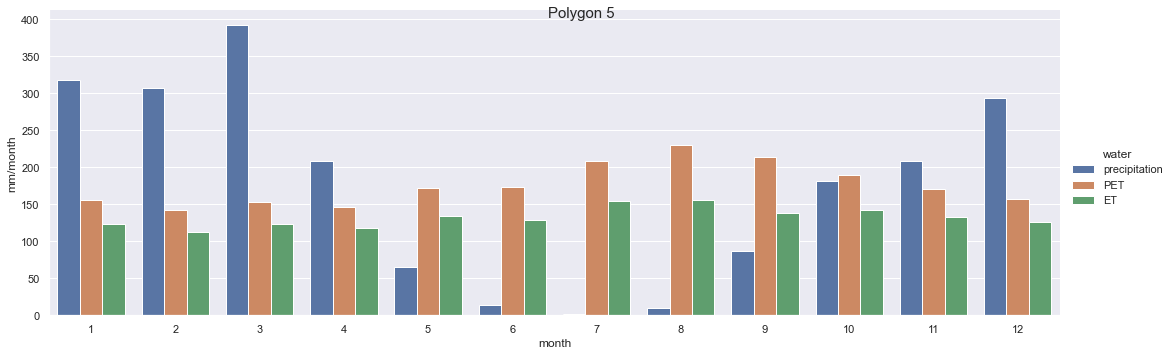

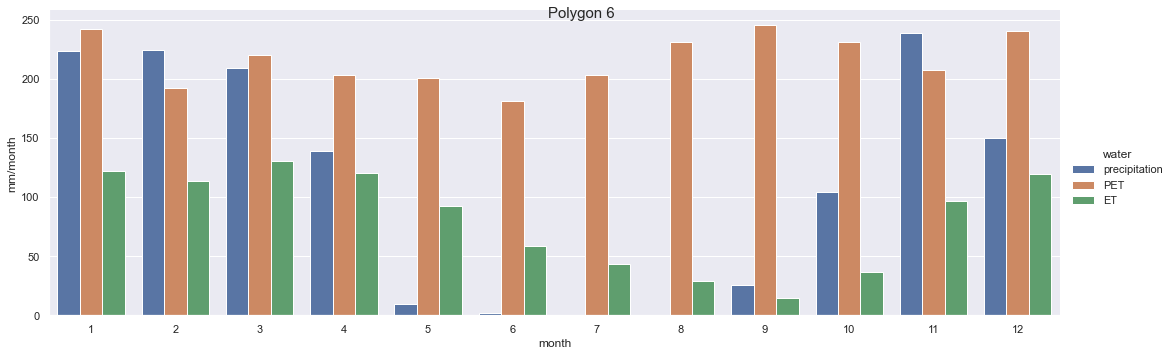

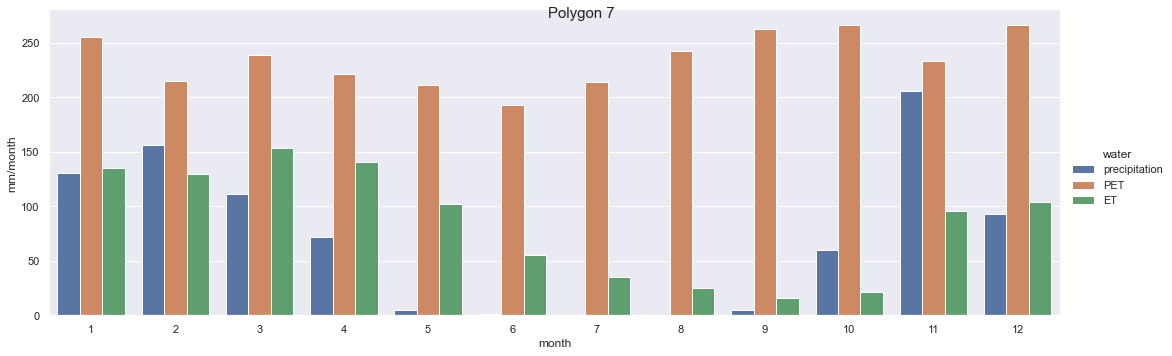

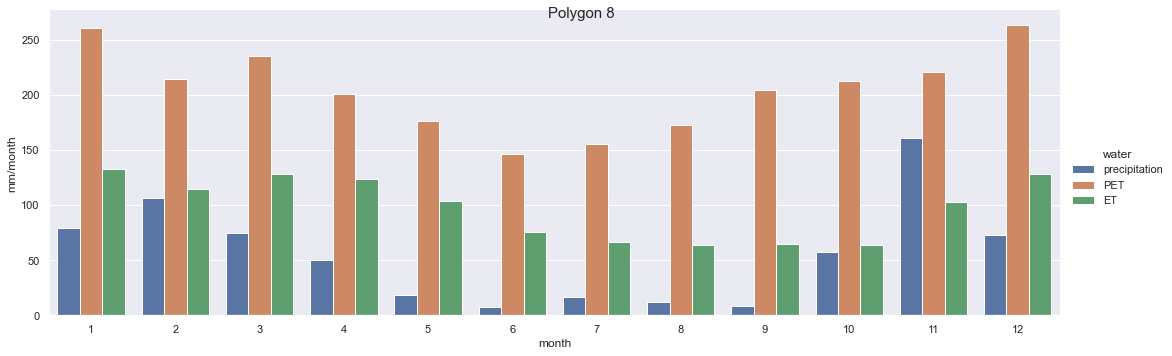

In [7]:
fig = plot.catplot_per_polygon(total_monthly_mean, 'month', 'mm/month', 'water', 'bar', ['precipitation', 'PET', 'ET'], title="bla")
plt.show()

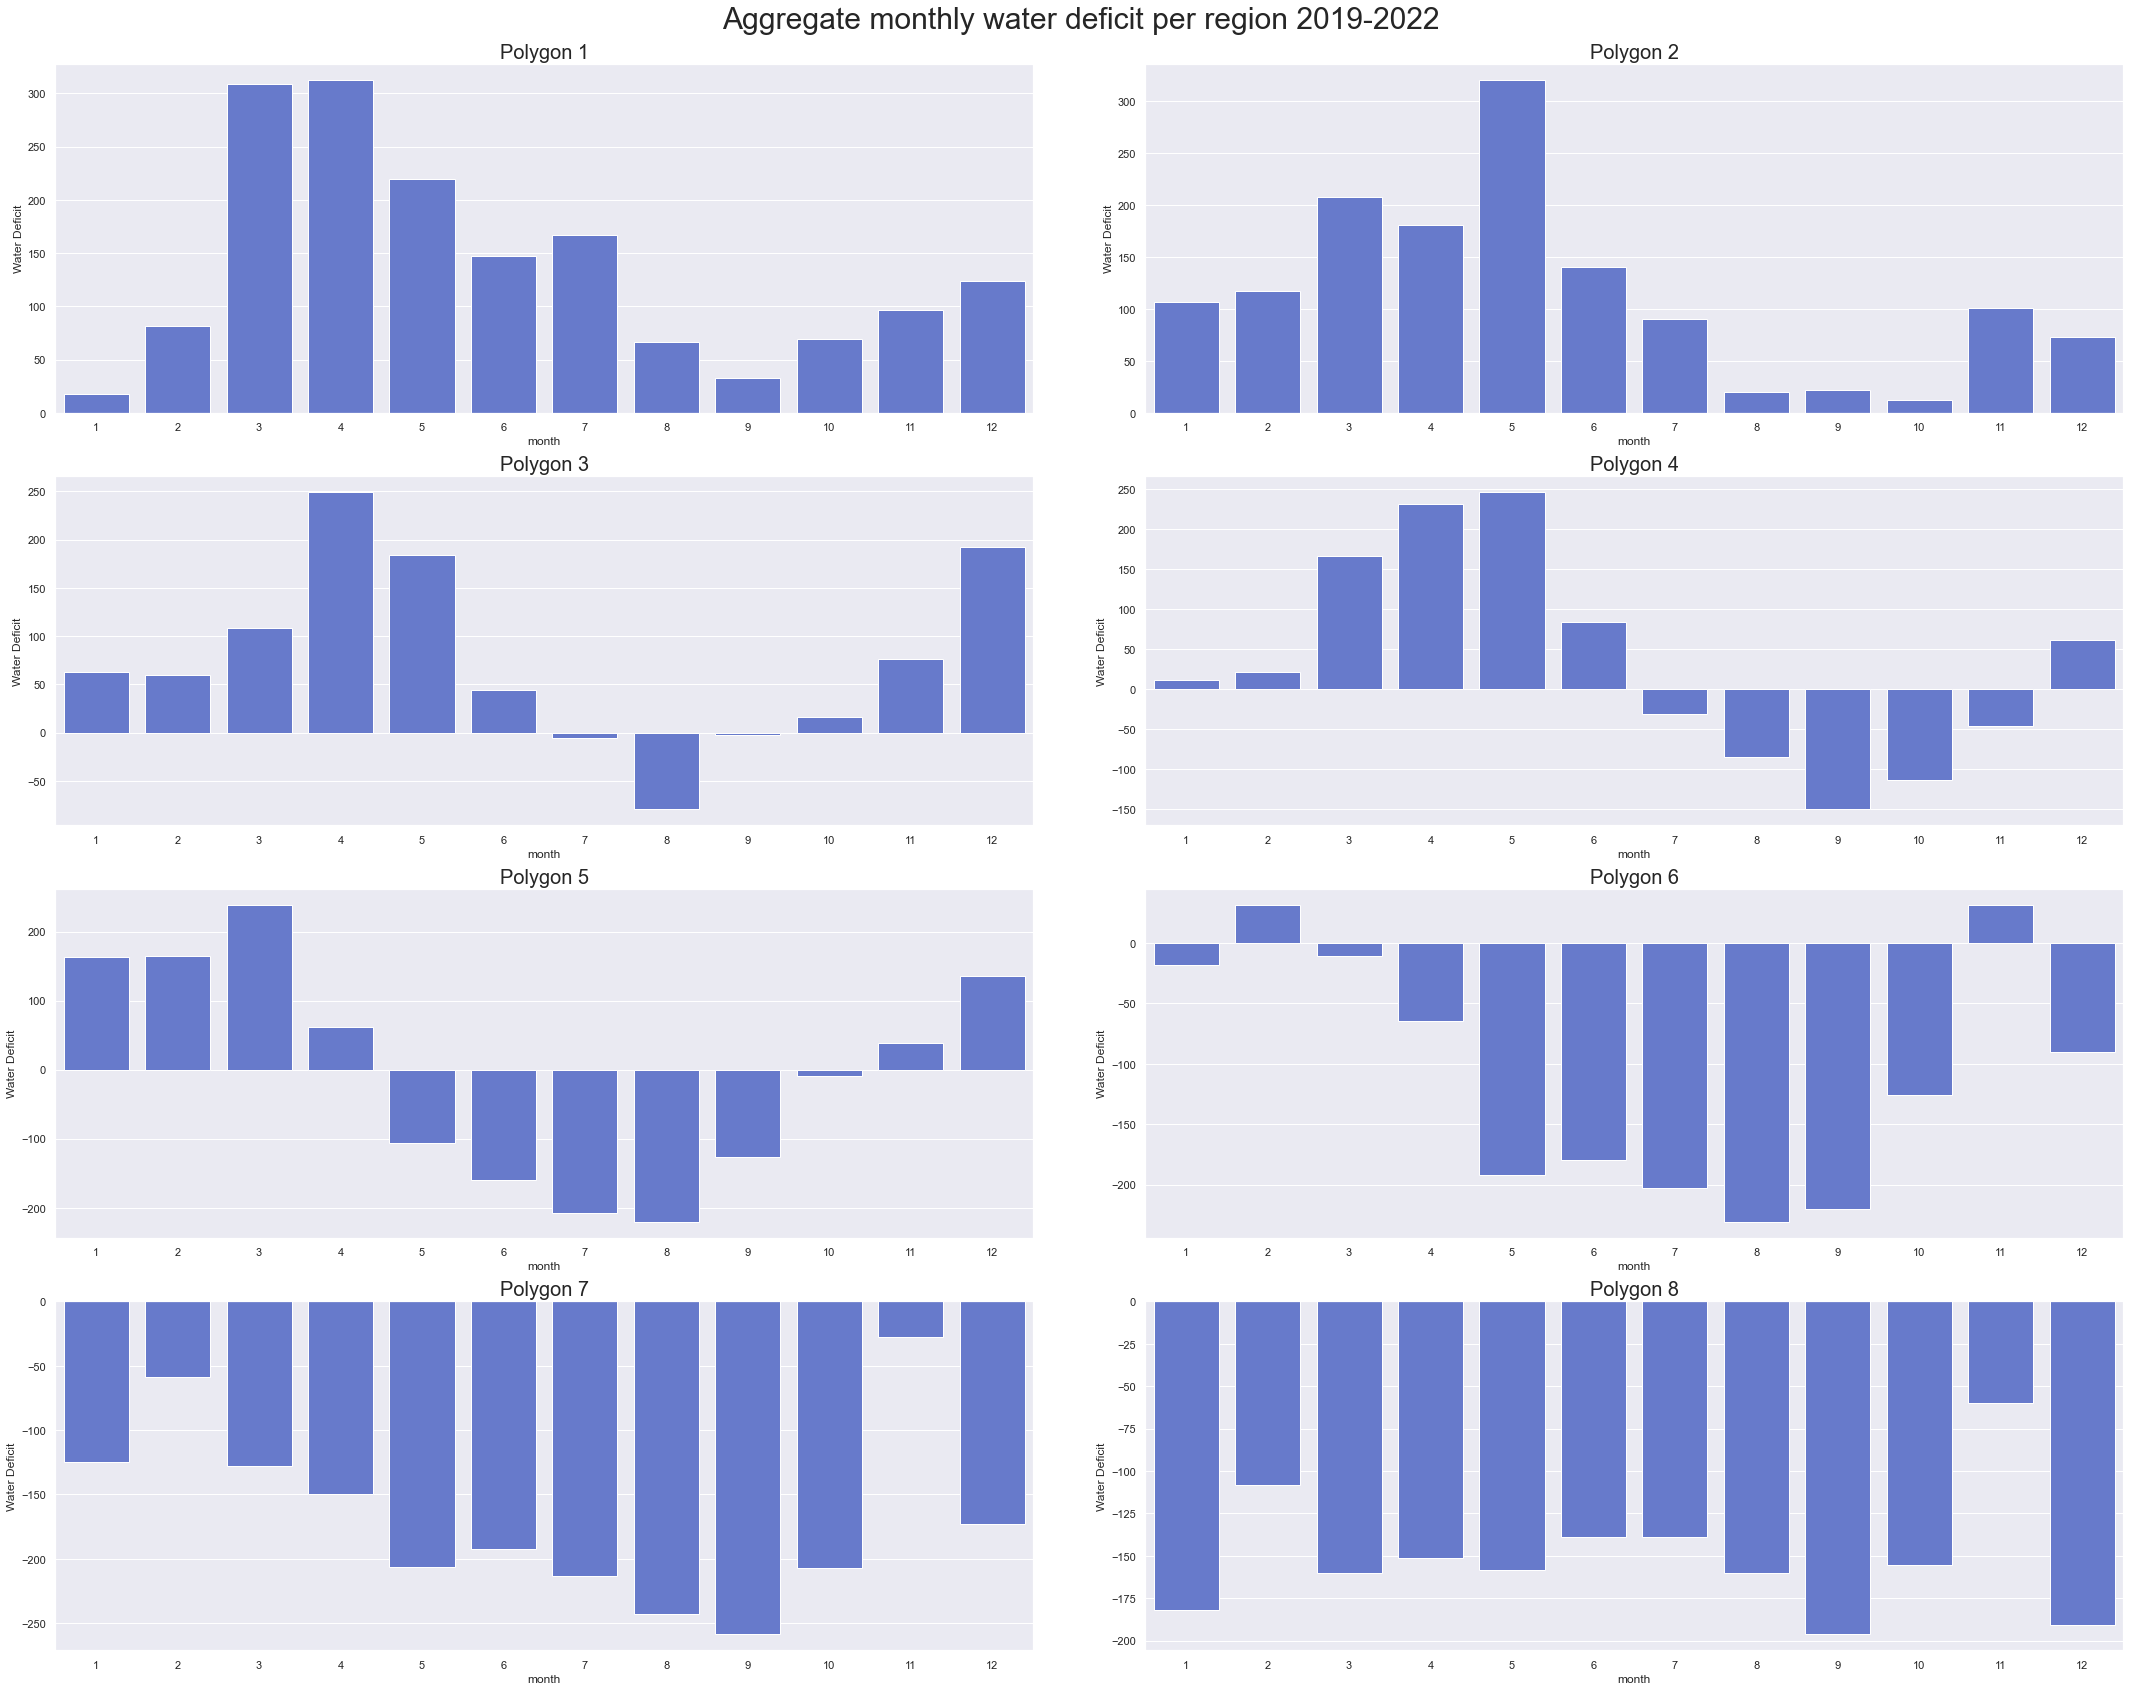

In [6]:
# Water deficit
total_monthly_mean['water_deficit'] = total_monthly_mean['precipitation'] - total_monthly_mean['PET']
# Plot aggregate monthly potential evapotranspiration per region.
fig = plot.barplot_per_polygon(total_monthly_mean,
                              x='month', 
                              y='water_deficit', 
                              ylabel="Water Deficit",
                              title="Aggregate monthly water deficit per region 2019-2022",
                              color=plot.palette[5])

plt.savefig(f'../../reports/figures/exploratory/total_monthly_water_deficit_2019_to_2022.png')
plt.show()

### Fetch and Save Climate Data for 2010-2022

In [2]:
# Dates of interest.
start_date_str = '2010-01-01'
end_date_str = '2022-11-01'

In [ ]:
# Dates of interest.
start_date = ee.Date(start_date_str)
end_date = ee.Date(end_date_str)

# Get regions of interest.
ee_geoms = pipeline.get_ee_polygons()

# Specify resolution.
scale = 5000

# NOTE: we partitioned the data fetch in two because otherwise we go over
# the Earth Engine limit, so we need to chunk.

# Fetch water-related variables.
precip_df = ee_climate.get_monthly_climate_data_as_pdf(
        start_date, end_date, ee_geoms, scale, columns=['precipitation', 'ET', 'PET'])

# Fetch other climate variables
radiation_pdf = ee_climate.get_monthly_climate_data_as_pdf(
        start_date, end_date, ee_geoms, scale, columns=['temperature', 'radiation', 'fpar'])

In [ ]:
precip_monthly_mean = precip_df.groupby(['month', 'polygon_id', 'year']) \
                               .mean(numeric_only=True).reset_index()
precip_monthly_mean = dfext.add_datetime_column(precip_monthly_mean)
precip_monthly_mean = dfext.add_date_column(precip_monthly_mean)
precip_monthly_mean['P-PET'] = precip_monthly_mean['precipitation'] - precip_monthly_mean['PET']
precip_monthly_mean['P-ET'] = precip_monthly_mean['precipitation'] - precip_monthly_mean['ET']

In [ ]:
radiation_monthly_mean = radiation_pdf.groupby(['month', 'polygon_id', 'year']) \
                                      .mean(numeric_only=True).reset_index()
radiation_monthly_mean = dfext.add_datetime_column(radiation_monthly_mean)
radiation_monthly_mean = dfext.add_date_column(radiation_monthly_mean)

In [ ]:
precip_monthly_mean.to_csv('../../data/interim/monthly_means_timeseries_of_water_climate_vars_01-2010_to_11-2022.csv')
radiation_monthly_mean.to_csv('../../data/interim/monthly_means_timeseries_of_radiation_vars_01-2010_to_11-2022.csv')

In [ ]:
# Join all climate vars.
climate_df = precip_monthly_mean.set_index(['month', 'polygon_id', 'year', 'datetime', 'date']) \
                                .join(radiation_monthly_mean.set_index(['month', 'polygon_id', 'year', 'datetime', 'date'])) \
                                .reset_index()

In [ ]:
climate_df.to_csv('../../data/interim/monthly_means_timeseries_of_climate_vars_01-2010_to_11-2022.csv')

### Fetch and Save Water Balance Data for 2001-2022

In [3]:
# Dates of interest.
start_date_str = '2001-01-01'
end_date_str = '2023-01-01'

In [ ]:
# Dates of interest.
start_date = ee.Date(start_date_str)
end_date = ee.Date(end_date_str)

# Get regions of interest.
ee_geoms = pipeline.get_ee_polygons()

# Specify resolution.
scale = 50000

# Fetch climate data from Earth Engine as Pandas DataFrame.
precip_df = ee_climate.get_monthly_climate_data_as_pdf(
        start_date, end_date, ee_geoms, scale, columns=['precipitation', 'PET'])

In [ ]:
precip_df.to_csv('../../data/interim/p_pet_2001-2023_scale_50km.csv')

In [7]:
precip_df = pd.read_csv('../../data/interim/p_pet_2001-2023_scale_50km.csv', index_col=0)

### Calculate and visualize Water Balance

From the "Spanish" paper: "An absolute measure of yearly climatic water balance was computed for each site to evaluate the effect of the latitudinal climatic gradient on forest response to drought. It corresponds to monthly precipitation minus potential evapotranspiration averaged across the 18 years."

In [9]:
# Calculate monthly water balance
precip_df['P-PET'] = precip_df.precipitation - precip_df.PET

In [14]:
# Calculate yearly averages
yearly_means = precip_df.groupby(['longitude', 'latitude', 'polygon_id', 'year']).mean(numeric_only=True).reset_index()

In [58]:
# Calculate yearly averages across 22 years
total_yearly_means = yearly_means.groupby(['longitude', 'latitude', 'polygon_id']).mean(numeric_only=True).reset_index().round(2)\
.sort_values('latitude', ascending=False).sort_values('longitude')

In [60]:
recent_yearly_means =yearly_means[yearly_means.year>=2019].groupby(['longitude', 'latitude', 'polygon_id']).mean(numeric_only=True).reset_index().round(2)\
.sort_values('latitude', ascending=False).sort_values('longitude')

In [27]:
import altair as alt

In [59]:
for polygon_id in range(1, 9):
    print(polygon_id)
    polygon_data = total_yearly_means[total_yearly_means.polygon_id==polygon_id]
    min = polygon_data['P-PET'].min()
    max = polygon_data['P-PET'].max()
    chart = alt.Chart(total_yearly_means[total_yearly_means.polygon_id==polygon_id]).mark_rect().encode(
        x='longitude:O',
        y= alt.Y('latitude:O', sort="descending"),
        color=alt.Color(
            'mean(P-PET):Q', scale=alt.Scale(scheme='redblue', domain=(min, max))),
        tooltip=[
            alt.Tooltip('longitude:O', title='Year'),
            alt.Tooltip('latitude:O', title='Month'),
            alt.Tooltip('mean(P-PET):Q', title='PDSI')
        ]).properties(width=300, height=300)
    chart.display()

1


alt.Chart(...)

2


alt.Chart(...)

3


alt.Chart(...)

4


alt.Chart(...)

5


alt.Chart(...)

6


alt.Chart(...)

7


alt.Chart(...)

8


alt.Chart(...)

In [61]:
for polygon_id in range(1, 9):
    print(polygon_id)
    polygon_data = recent_yearly_means[recent_yearly_means.polygon_id==polygon_id]
    min = polygon_data['P-PET'].min()
    max = polygon_data['P-PET'].max()
    chart = alt.Chart(polygon_data).mark_rect().encode(
        x='longitude:O',
        y= alt.Y('latitude:O', sort="descending"),
        color=alt.Color(
            'mean(P-PET):Q', scale=alt.Scale(scheme='redblue', domain=(min, max))),
        tooltip=[
            alt.Tooltip('longitude:O', title='Year'),
            alt.Tooltip('latitude:O', title='Month'),
            alt.Tooltip('mean(P-PET):Q', title='PDSI')
        ]).properties(width=300, height=300)
    chart.display()

1


alt.Chart(...)

2


alt.Chart(...)

3


alt.Chart(...)

4


alt.Chart(...)

5


alt.Chart(...)

6


alt.Chart(...)

7


alt.Chart(...)

8


alt.Chart(...)

### Get Aggregate water climatic balanse per polygon

recent_yearly_means =yearly_means[yearly_means.year>=2019].groupby(['longitude', 'latitude', 'polygon_id']).mean(numeric_only=True).reset_index().round(2)\
.sort_values('latitude', ascending=False).sort_values('longitude')

[Text(0.5, 1.0, '20 year avg water balance with Spatial and temporal variation within each polygon')]

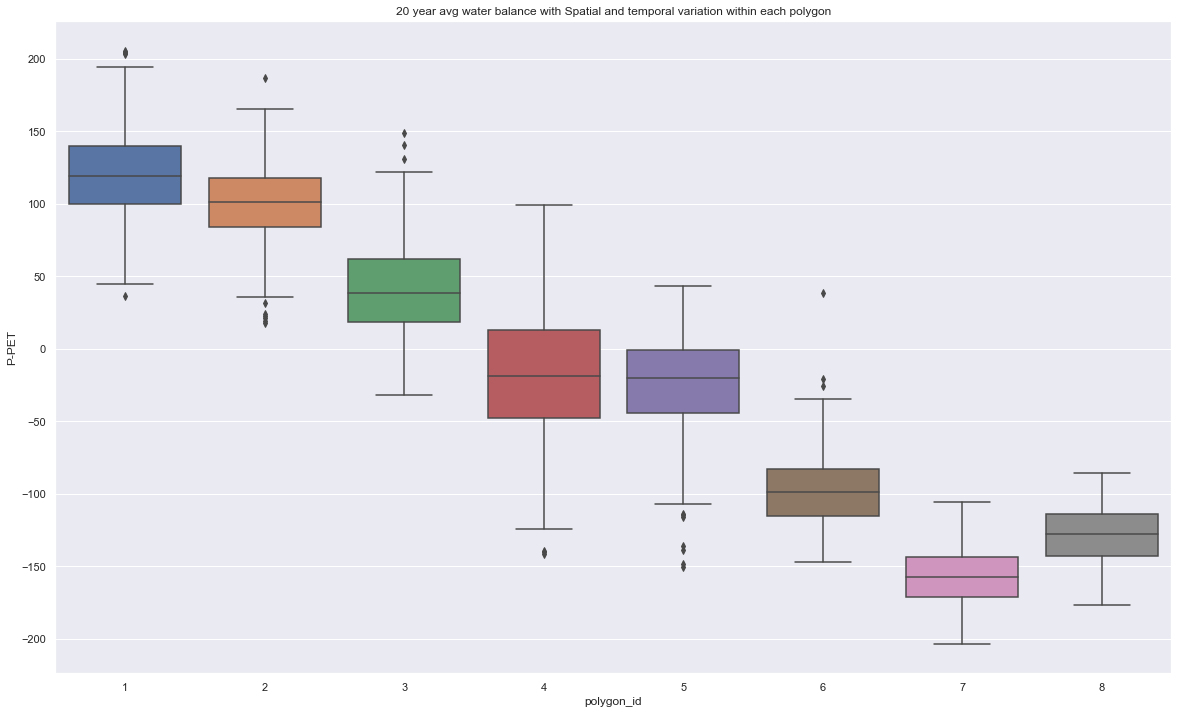

In [73]:
import seaborn as sns
plt.rcParams['figure.figsize'] = [20, 12]

# Shows both time and space variance
sns.boxplot(yearly_means, x='polygon_id', y='P-PET').set(title="20 year avg water balance with Spatial and temporal variation within each polygon")

[Text(0.5, 1.0, '20 year avg water balance with Spatial variation within each polygon')]

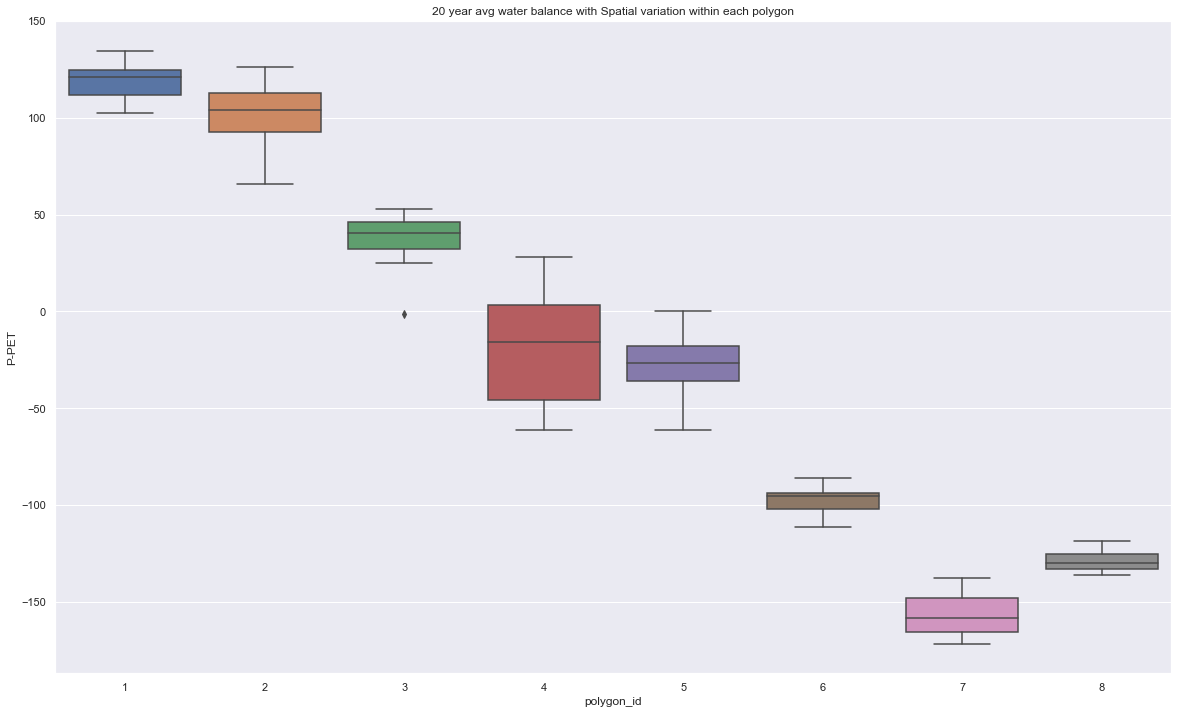

In [71]:
sns.boxplot(yearly_means.groupby(['longitude', 'latitude', 'polygon_id']).mean().reset_index(), x='polygon_id', y='P-PET').set(title='20 year avg water balance with Spatial variation within each polygon')

Text(0.5, 1.0, 'Annual Average Water Balance per Polygon')

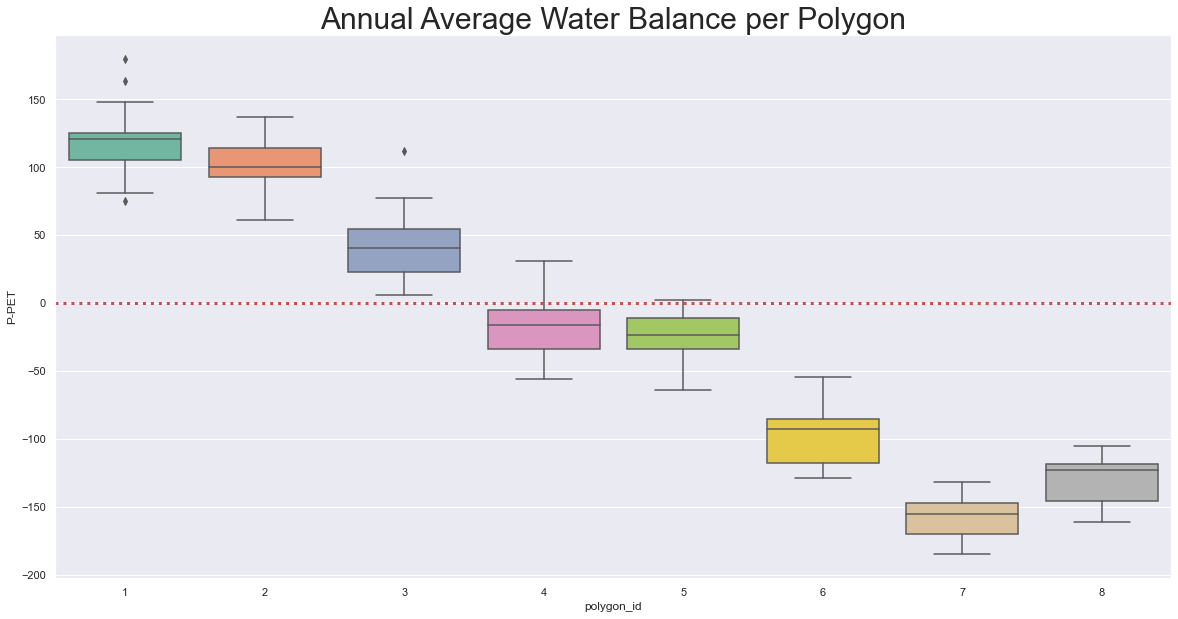

In [115]:
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(yearly_means.groupby(['year', 'polygon_id']).mean().reset_index(), x='polygon_id', y='P-PET', ax=ax, palette=sns.color_palette("Set2"))
ax.axhline(y = 0, color = 'r', linestyle = 'dotted', linewidth=3)
ax.axes.set_title('Annual Average Water Balance per Polygon', fontsize=30)

Text(0.5, 1.0, 'Annual Average Water Balance')

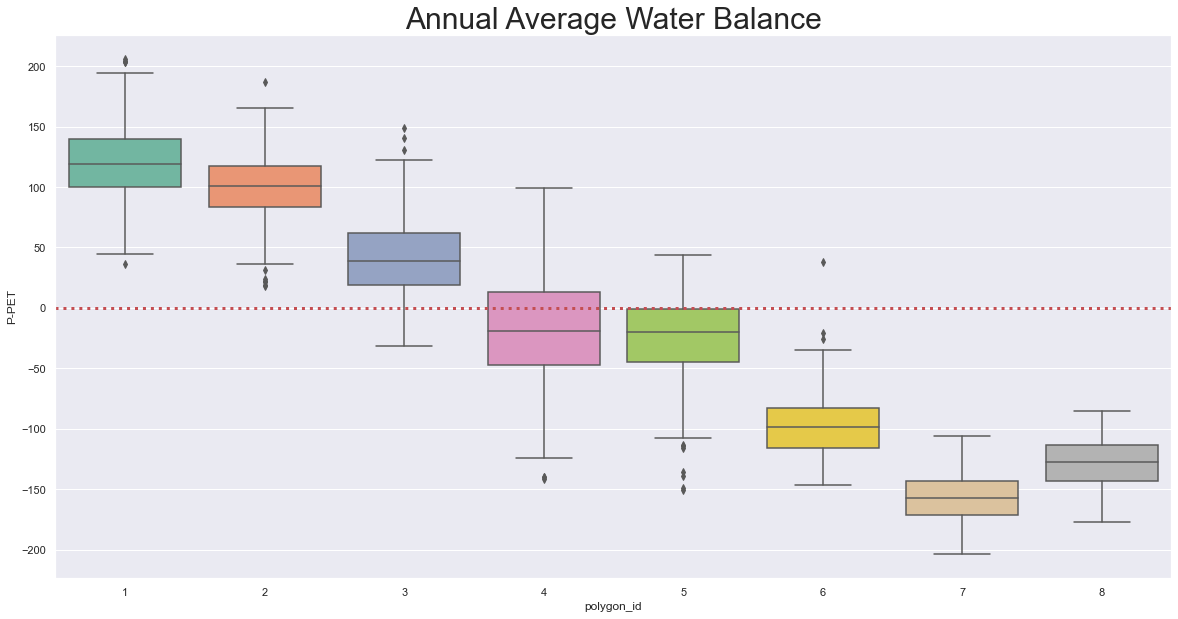

In [122]:
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(yearly_means, x='polygon_id', y='P-PET', ax=ax, palette=sns.color_palette("Set2"))
ax.axhline(y = 0, color = 'r', linestyle = 'dotted', linewidth=3)
ax.axes.set_title('Annual Average Water Balance', fontsize=30)

In [87]:
yearly_means.groupby(['polygon_id']).mean().reset_index()

,polygon_id,longitude,latitude,year,time,month,precipitation,PET,P-PET
0,1,-73.661853,-1.347473,2011.500000,1.324900e+12,6.827946,272.266852,152.485588,119.781264
1,2,-66.924489,-0.449158,2011.500000,1.324456e+12,6.660104,249.875800,148.489786,101.386014
2,3,-61.128184,-2.203044,2011.531722,1.325742e+12,6.769602,193.424403,152.234662,41.189742
3,4,-56.144705,0.000000,2011.500000,1.325983e+12,7.241576,168.024264,186.177557,-18.153294
4,5,-53.043346,-8.519747,2011.531722,1.325356e+12,6.624740,151.339458,176.491425,-25.151967
5,6,-48.059868,-13.025572,2011.500000,1.323988e+12,6.483118,117.176951,214.398818,-97.221867
6,7,-44.466607,-11.228941,2011.500000,1.324022e+12,6.495558,73.652525,231.225338,-157.572813
7,8,-41.322503,-16.618833,2011.500000,1.323994e+12,6.485072,71.810090,200.640075,-128.829986


Text(0.5, 1.0, 'Average Monthly Precipitation per Polygon')

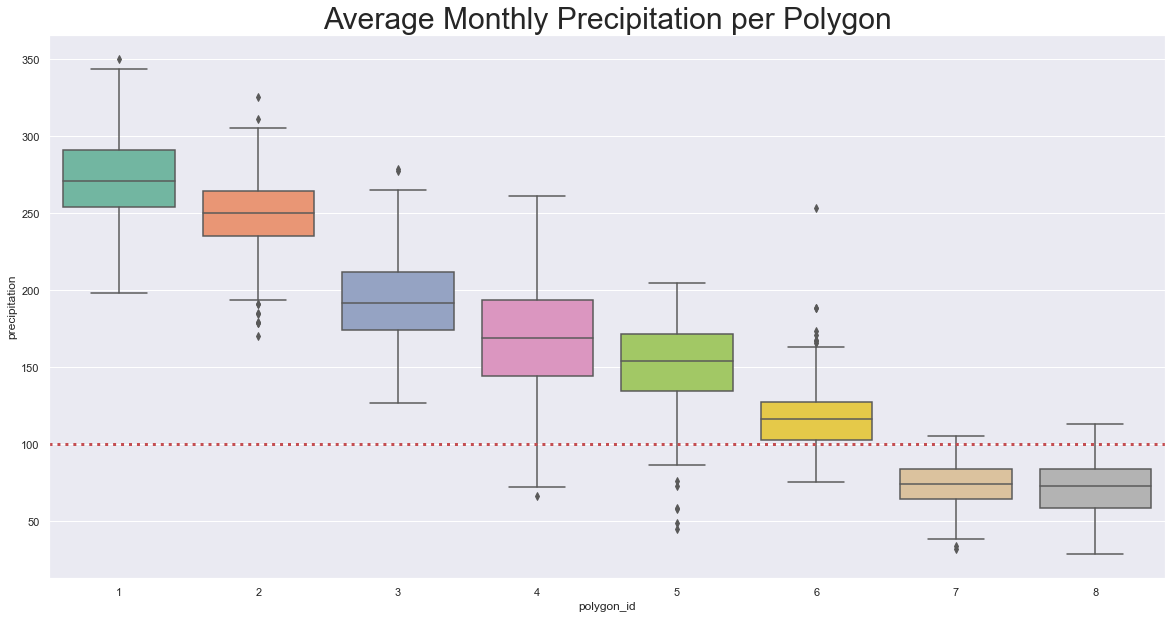

In [119]:
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(yearly_means, x='polygon_id', y='precipitation', ax=ax, palette=sns.color_palette("Set2"))
ax.axhline(y = 100, color = 'r', linestyle = 'dotted', linewidth=3)
ax.axes.set_title('Average Monthly Precipitation per Polygon', fontsize=30)

Text(0.5, 1.0, 'Average Monthly Precipitation per Polygon')

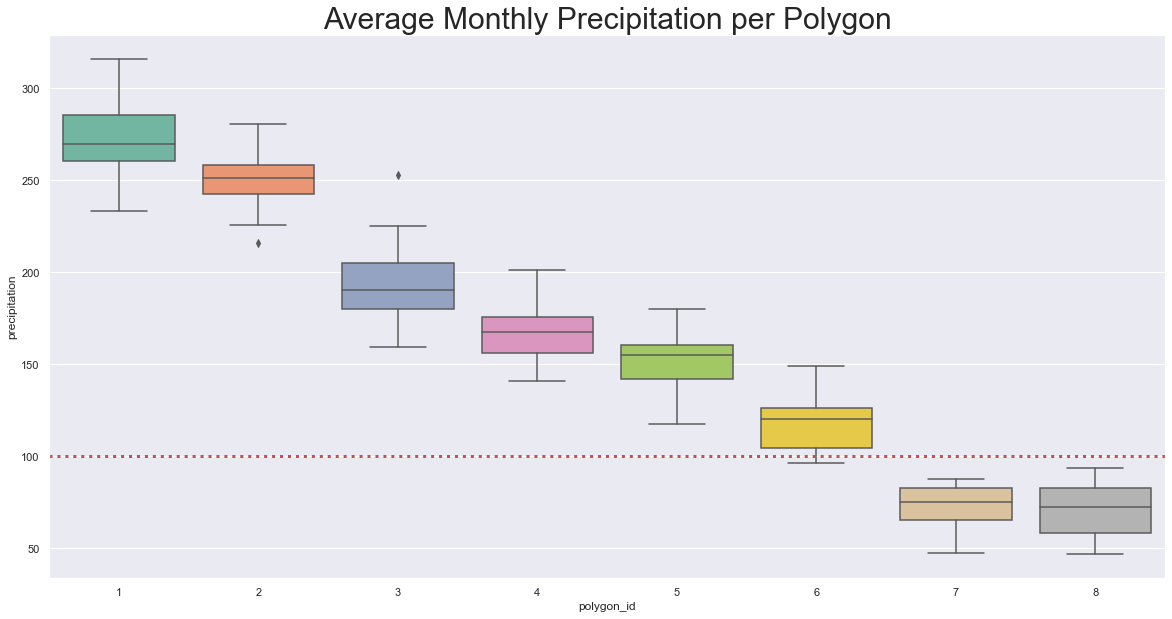

In [120]:
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(yearly_means.groupby(['year', 'polygon_id']).mean().reset_index(), x='polygon_id', y='precipitation', ax=ax, palette=sns.color_palette("Set2"))
ax.axhline(y = 100, color = 'r', linestyle = 'dotted', linewidth=3)
ax.axes.set_title('Average Monthly Precipitation per Polygon', fontsize=30)

### Plot PAI

monthly_data = pipeline.get_monthly_means_per_polygon()

In [123]:
monthly_data = pipeline.get_monthly_means_per_polygon()

Text(0.5, 1.0, 'Average Monthly Plant Area Index')

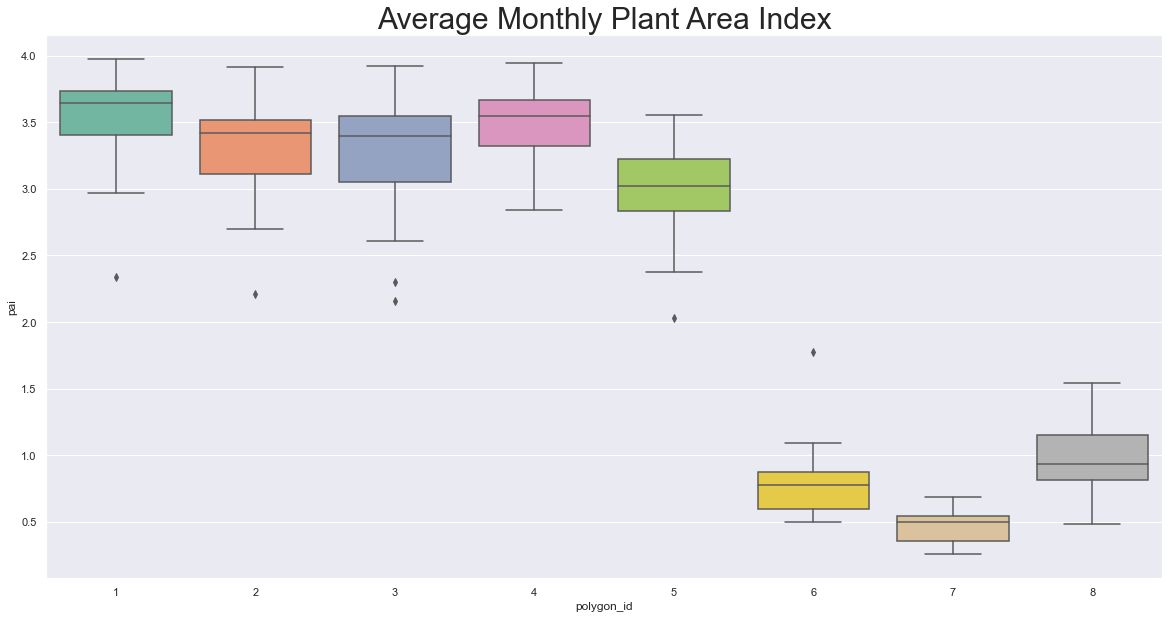

In [127]:
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(monthly_data, x='polygon_id', y='pai', ax=ax, palette=sns.color_palette("Set2"))
ax.axes.set_title('Average Monthly Plant Area Index', fontsize=30)

Text(0.5, 1.0, 'Coefficient of Variation of Plant Area Index')

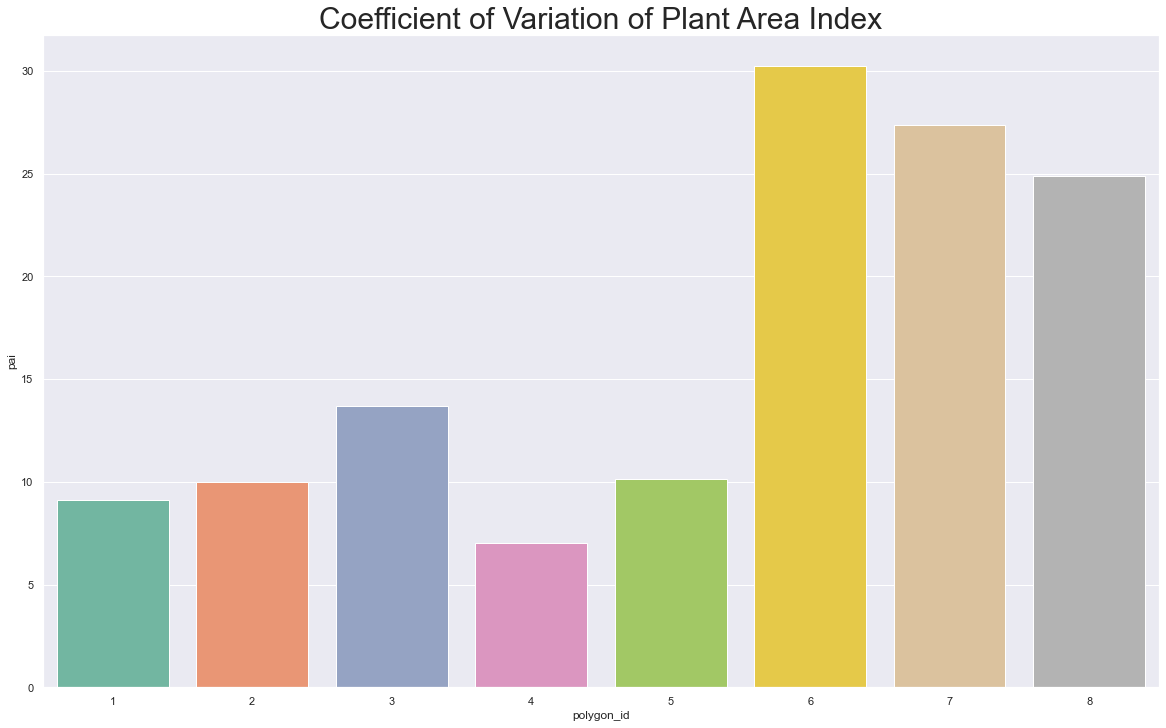

In [143]:
pai_cv = ((monthly_data.groupby('polygon_id').std().pai / monthly_data.groupby('polygon_id').mean().pai) * 100).reset_index()
ax = sns.barplot(pai_cv, x='polygon_id', y='pai', palette=sns.color_palette("Set2"))
ax.axes.set_title('Coefficient of Variation of Plant Area Index', fontsize=30)


In [148]:
monthly_data

,month,year,polygon_id,pai,precipitation,temperature,radiation
0,1,2020,1,3.676017,111.927796,30.139926,1.533163e+07
1,1,2020,2,3.368554,196.966859,28.646051,1.516526e+07
2,1,2020,3,2.606483,158.619501,29.270302,1.568071e+07
3,1,2020,4,3.794207,125.071252,27.873457,1.435729e+07
4,1,2020,5,3.301465,292.113777,27.333688,1.424309e+07
...,...,...,...,...,...,...,...
294,12,2021,4,3.087010,329.821745,27.801845,1.333075e+07
295,12,2021,5,2.885736,337.831219,27.371466,1.159784e+07
296,12,2021,6,0.806422,466.951728,29.931494,1.140797e+07
297,12,2021,7,0.585766,299.846644,30.686953,1.371934e+07


/var/folders/2q/26zyw9sd5cldkn81_ymfw6dh0000gn/T/ipykernel_92761/2944127767.py:1: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.scatterplot(monthly_data[monthly_data.polygon_id==5], x='precipitation', y='pai', hue='polygon_id', s=100, palette=sns.color_palette("Set2"))


<AxesSubplot: xlabel='precipitation', ylabel='pai'>

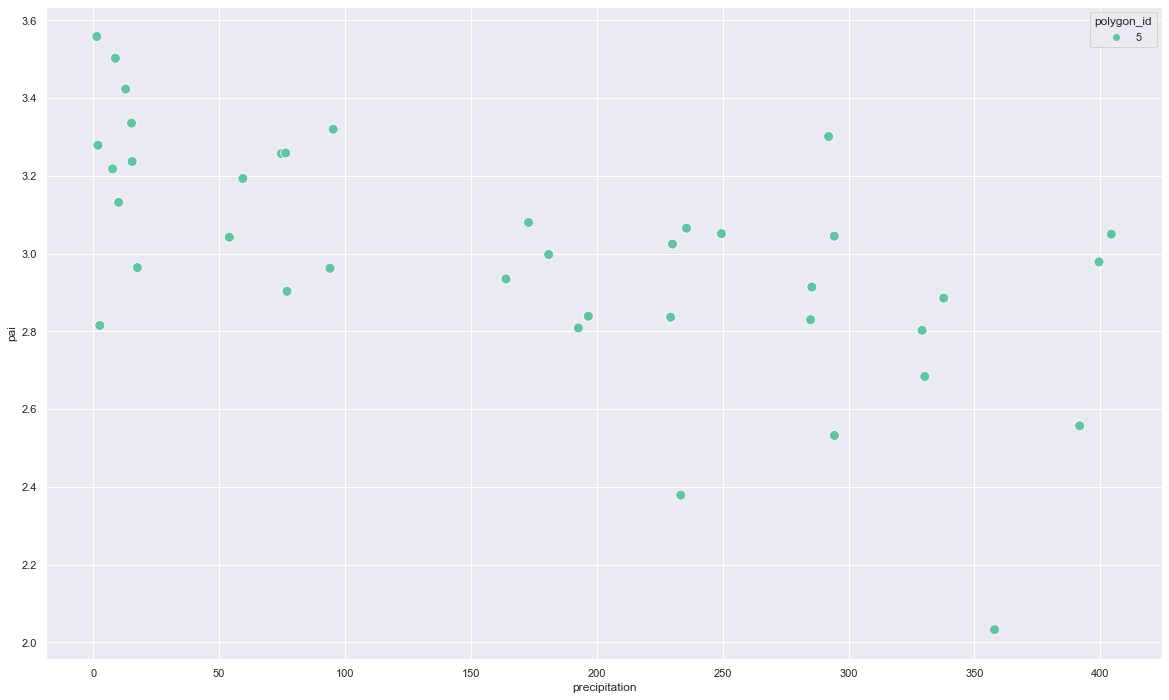

In [160]:
sns.scatterplot(monthly_data[monthly_data.polygon_id==5], x='precipitation', y='pai', hue='polygon_id', s=100, palette=sns.color_palette("Set2"))

<AxesSubplot: xlabel='radiation', ylabel='pai'>

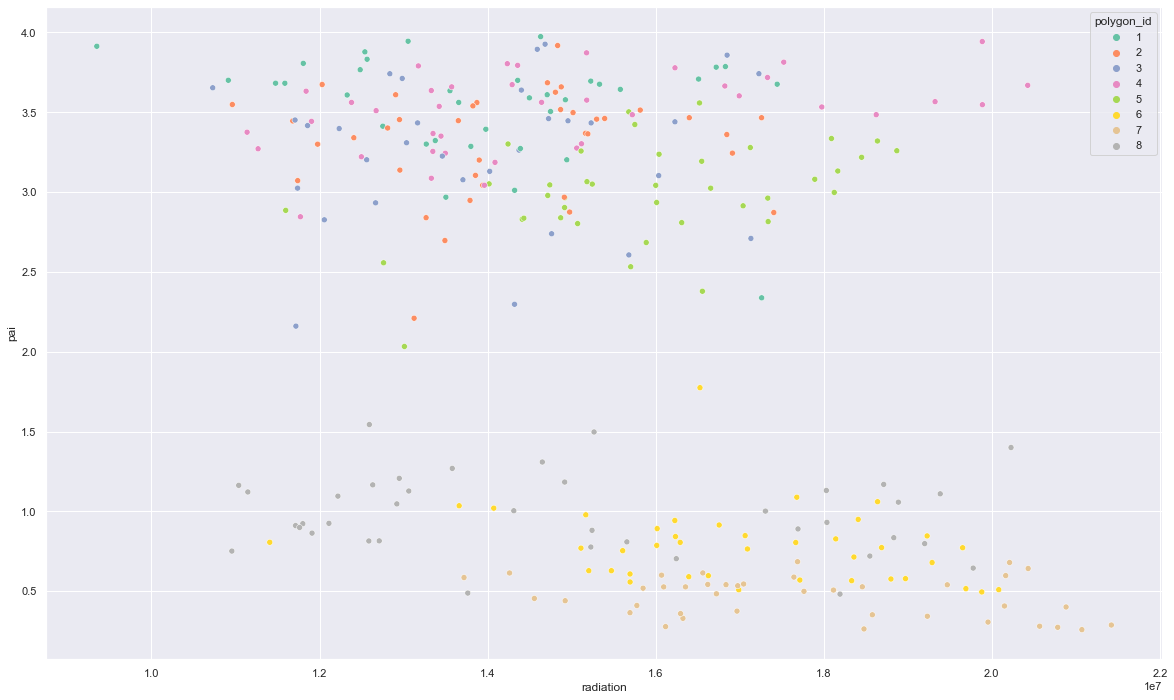

In [149]:
sns.scatterplot(monthly_data, x='radiation', y='pai', hue='polygon_id', palette=sns.color_palette("Set2"))

In [163]:
monthly_data = dfext.add_date_column(monthly_data).sort_values('date')

In [167]:
def shift_data(df, column, amount):
    # Polygon 1.
    all_polygons = []
    for polygon_id in range(1, 9):
        polygon_climate = df[(df.polygon_id==polygon_id)].sort_values('date')
        for i in range(0, amount + 1):
            if i==0:
                continue
            polygon_climate[f"{column}_{i}"] = polygon_climate[column].shift(i)
        all_polygons.append(polygon_climate)
    return pd.concat(all_polygons)

In [176]:
shifted = shift_data(shifted, 'pai', 1)

In [178]:
shifted['delta_pai'] = shifted.pai - shifted.pai_1

<AxesSubplot: xlabel='precipitation_2', ylabel='delta_pai'>

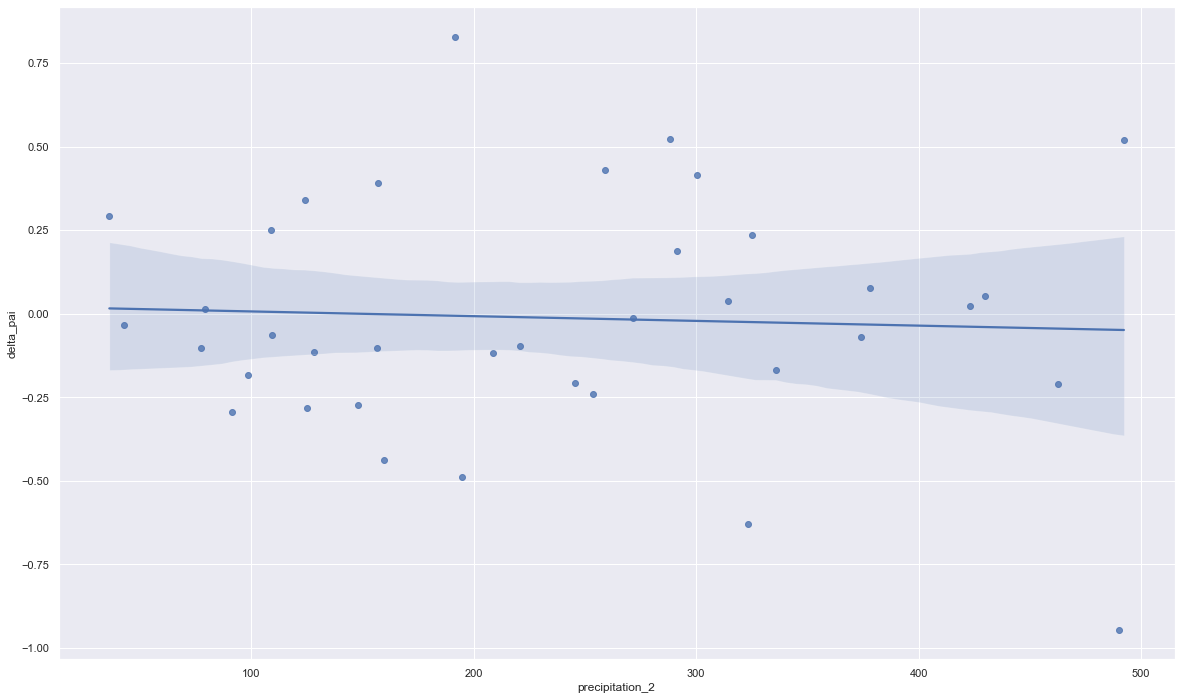

In [193]:
sns.regplot(shifted[shifted.polygon_id==4], x='precipitation_2', y='delta_pai',)

<AxesSubplot: xlabel='precipitation', ylabel='pai'>

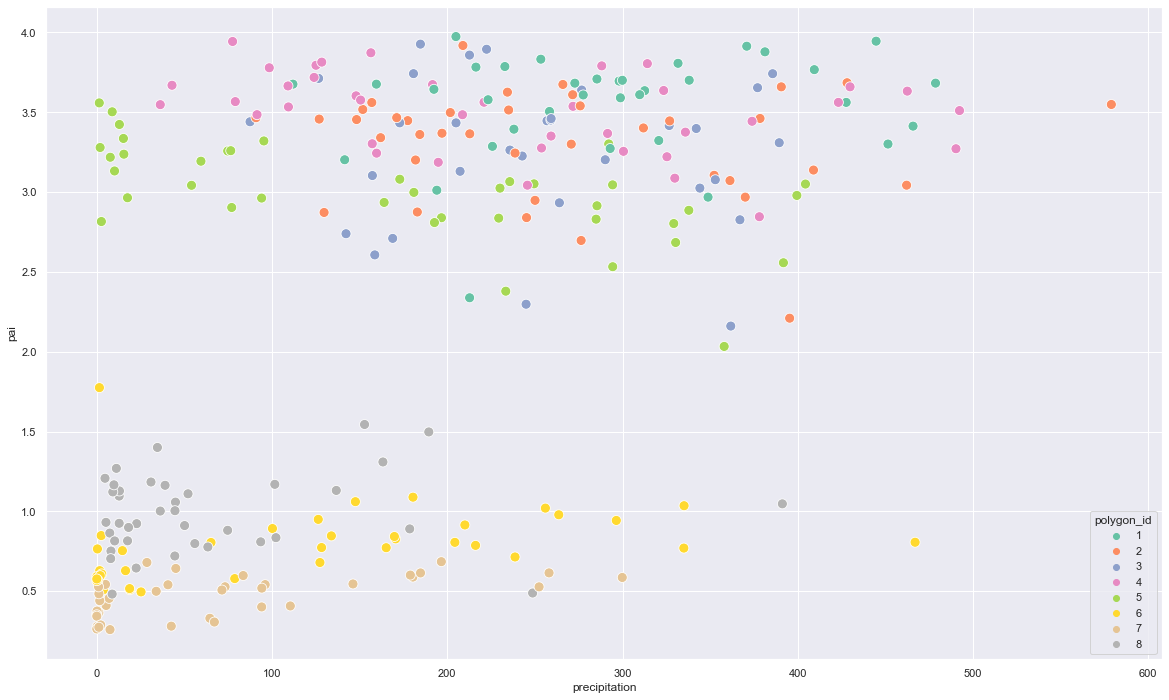

In [172]:
sns.scatterplot(monthly_data, x='precipitation', y='pai', hue='polygon_id', s=100, palette=sns.color_palette("Set2"))

/var/folders/2q/26zyw9sd5cldkn81_ymfw6dh0000gn/T/ipykernel_92761/994933983.py:1: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.scatterplot(shifted[shifted.polygon_id > 5], x='precipitation', y='delta_pai', hue='polygon_id', s=100, palette=sns.color_palette("Set2"))


<AxesSubplot: xlabel='precipitation', ylabel='delta_pai'>

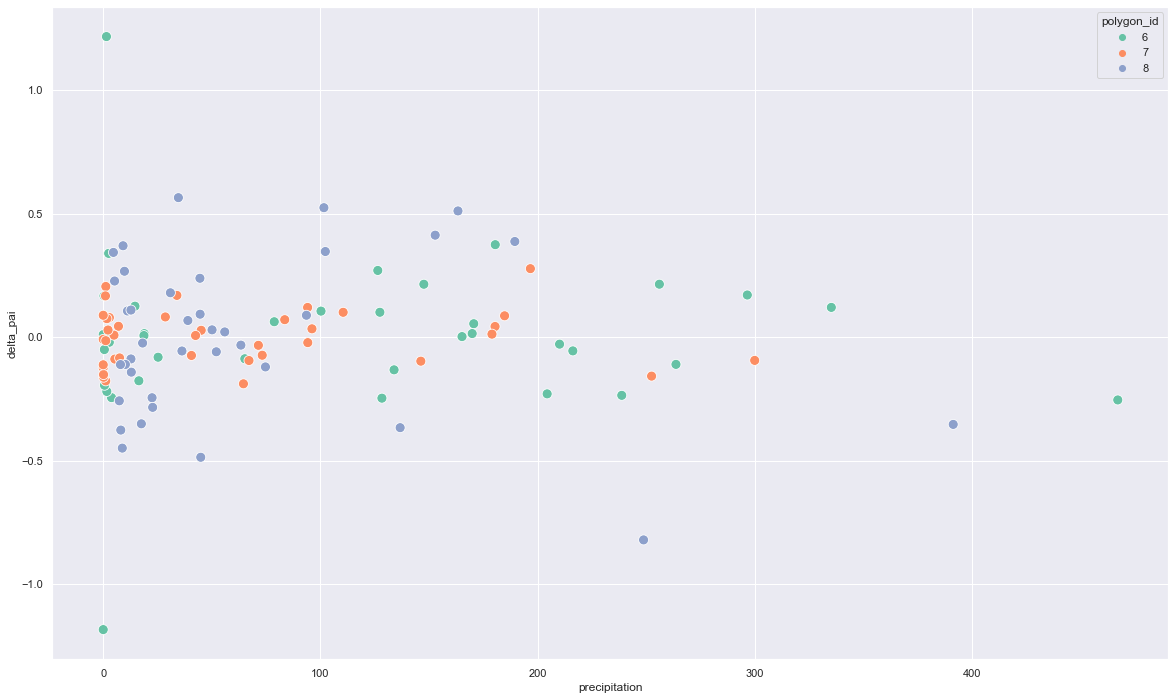

In [196]:
sns.scatterplot(shifted[shifted.polygon_id > 5], x='precipitation', y='delta_pai', hue='polygon_id', s=100, palette=sns.color_palette("Set2"))